# Convolutional neural networks

## Digit recognition

In [2]:
import matplotlib.pyplot as plt
from keras.api._v2.keras.datasets import mnist

(60000, 28, 28)


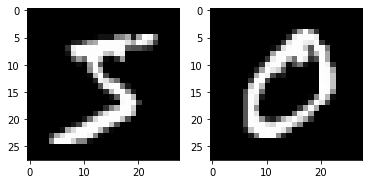

In [3]:
# Let's load the famous MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.
X_test = X_test / 255.

print(X_train.shape)
plt.subplot(1,2,1)
plt.imshow(X_train[0], cmap="gray");
plt.subplot(1,2,2)
plt.imshow(X_train[1], cmap="gray");

In [4]:
# Reshape the X to explicitly add a single "color" channel
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)
X_train.shape

(60000, 28, 28, 1)

In [6]:
# One Hot Encode our Target for TensorFlow processing
from keras.api._v2.keras.utils import to_categorical
y_cat_train = to_categorical(y_train, num_classes=10)
y_cat_test = to_categorical(y_test, num_classes=10)
y_cat_train.shape

(60000, 10)

In [8]:
from keras.api._v2.keras import layers, models

In [9]:
# ——— CNN Version 1: Minimal Network
model = models.Sequential()
model.add(layers.Conv2D(16, (4,4), input_shape=(28, 28, 1), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

2022-08-17 10:29:46.758086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 10:29:46.758321: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 10:29:46.758408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (RSOLE): /proc/driver/nvidia/version does not exist
2022-08-17 10:29:46.761410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# ——— CNN Version 2: Common Tricks
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), input_shape=(28, 28, 1), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu')) # intermediate layer
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_1 (Dense)             (None, 50)               

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_cat_train,
          epochs=1,  # Use early stopping in practice
          batch_size=32, 
          verbose=1,
          workers=7,
          use_multiprocessing=True)

1875/1875 [==============================] - 49s 26ms/step - loss: 0.0640 - accuracy: 0.9808


In [12]:
# We now evaluate on the test data
print(model.evaluate(X_test, y_cat_test, verbose=0))

[0.06363681703805923, 0.9817000031471252]


In [15]:
# ——— CNN Version III: 

# - Integrate Preprocessing Layers
# - Add Regularization

# Reload raw data
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

model_pipe = models.Sequential([
    layers.Reshape((28, 28, 1), input_shape=(28,28)),
    layers.experimental.preprocessing.Rescaling(scale=1./255.),
    layers.Conv2D(16, (3,3), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(32, (2,2), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_pipe.compile(loss='sparse_categorical_crossentropy', # No need to OHE target
              optimizer='adam',
              metrics=['accuracy'])

model_pipe.fit(X_train_raw, y_train_raw, 
          epochs=1,  # Use early stopping in practice
          batch_size=32, 
          verbose=1,
          workers=7,
          use_multiprocessing=True)

1875/1875 [==============================] - 56s 29ms/step - loss: 0.2829 - accuracy: 0.9134


In [16]:
## We can now evaluate the model on the test data
print(model_pipe.evaluate(X_test_raw, y_test_raw, verbose=0))

[0.07873501628637314, 0.9742000102996826]


## Insights of the model

In [17]:
# Let's focus on the first convolutional layer
layer_1 = model.layers[0]
layer_1

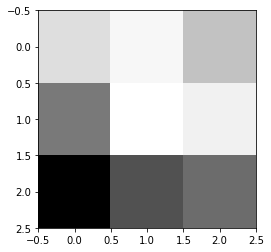

In [18]:
# You can access its 16 kernels. Let's print the last one
plt.imshow(layer_1.weights[0][:,:,:,15], cmap='gray');

In [19]:
# We can also compute the output of the first layer (called it's activation)
# By calling it with a "batch" of images (let's take 10)
batch = X_train[0:10]
activation_1 = layer_1(batch)
activation_1.shape

TensorShape([10, 28, 28, 16])

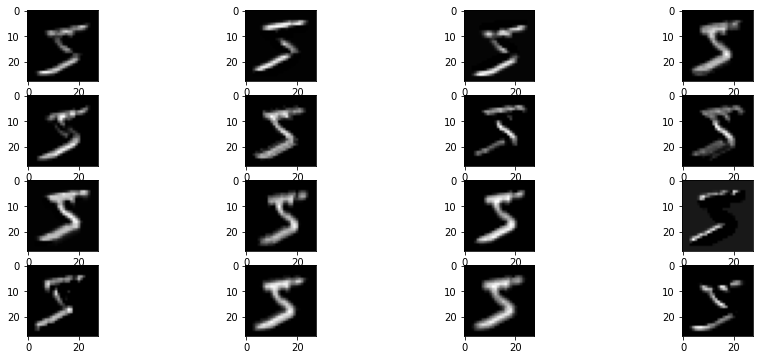

In [20]:
# Let's display all 16 channels' outputs of the first layer, applied to the first image only

fig, axs = plt.subplots(4,4, figsize=(15,6))
for i in range(4):
    for j in range(4):
        feature_map = activation_1[0,:,:,4*i+j]
        axs[i,j].imshow(feature_map, cmap='gray')